# Сегментация радионуклидных изображений печени

### Импорты

In [1]:
import os
import random
from os.path import join as pjoin
import albumentations
import numpy as np
import torch
from PIL import Image
from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2
from dataset import CustomDataset
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from train import (
    CheckpointSaver,
    load_checkpoint,
    train,
)
from unet import UNet, count_model_params
from metric import MeanIoU
from loss import DiceLoss

### Установка начального значения генераторов случайных чисел

In [2]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)
seed_everything(42, torch_deterministic=False)

### Преобразования изображений (аугментации)

In [3]:
IMAGE_SIZE = 256
transforms = albumentations.Compose(
    [
        albumentations.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        ToTensorV2(),
    ]
)

### Примеры радионуклидных ихображений печени и соответсвующих им масок

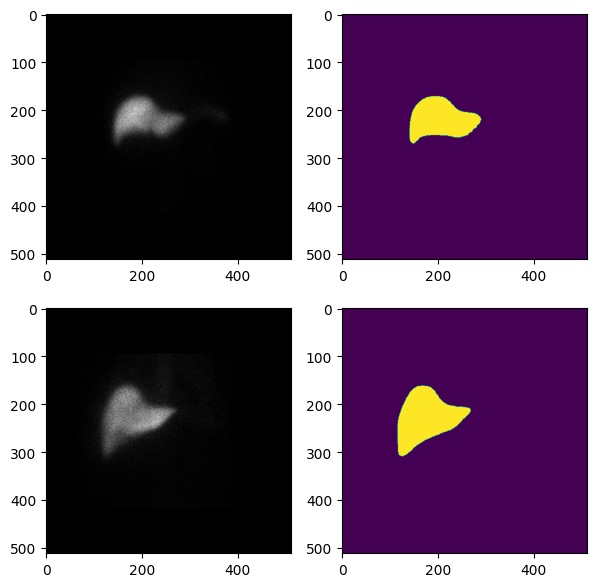

In [4]:
image1 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/images/image (2).png")
mask1 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/masks/mask_image (2).png")
image2 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/images/image (3).png")
mask2 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/masks/mask_image (3).png")
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax[0, 0].imshow(image1)
ax[0, 1].imshow(mask1)
ax[1, 0].imshow(image2)
ax[1, 1].imshow(mask2)

### Разделение датасета на тренировочный, валидационный и тестовый (70/20/10)

In [5]:
full_dataset = CustomDataset(root_dir="C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data",transforms = transforms)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
print('Количество изображений в полном датасете:',len(full_dataset))
print('Количество изображений в тренировочном датасете:',len(train_dataset))
print('Количество изображений в валидационном датасете:',len(val_dataset))
print('Количество изображений в тестовом датасете:',len(test_dataset))


Количество изображений в полном датасете: 253
Количество изображений в тренировочном датасете: 177
Количество изображений в валидационном датасете: 50
Количество изображений в тестовом датасете: 26


### Настройка гиперпараметров

In [6]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_WORKERS = 2
EPOCH_NUM = 20
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Создание модели

In [7]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)

model = UNet(in_channels=3, out_channels=1)

loss_fn = DiceLoss()
metric_fn = MeanIoU()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=5, gamma=0.8
) #уменьшение скорости обучения

### Количество параметров модели

In [8]:
count_model_params(model)

17262977

### Подготовка модели, данных и оптимизатора к обучению

In [9]:
accelerator = Accelerator(cpu=False, mixed_precision="fp16")
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name="DICE",
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=False,
)
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

### Обучение модели

In [10]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_function=loss_fn,
    metric_function=metric_fn,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------
Epoch 0/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.71868
Batch train metric: 0.71558
Epoch train loss: 0.77827
Epoch train metric: 0.55230


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.76829
Epoch validation metric: 0.58532
Best epoch DICE value is 0.5853 on 0 epoch
------------------------------
Epoch 1/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.72776
Batch train metric: 0.78211
Epoch train loss: 0.73537
Epoch train metric: 0.69246


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.74430
Epoch validation metric: 0.70505
Best epoch DICE value is 0.7050 on 1 epoch
------------------------------
Epoch 2/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.69346
Batch train metric: 0.81959
Epoch train loss: 0.71572
Epoch train metric: 0.73614


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.72447
Epoch validation metric: 0.76650
Best epoch DICE value is 0.7665 on 2 epoch
------------------------------
Epoch 3/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.63800
Batch train metric: 0.85544
Epoch train loss: 0.69384
Epoch train metric: 0.76771


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.71414
Epoch validation metric: 0.77151
Best epoch DICE value is 0.7715 on 3 epoch
------------------------------
Epoch 4/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.70226
Batch train metric: 0.60966
Epoch train loss: 0.66974
Epoch train metric: 0.80342


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.67616
Epoch validation metric: 0.74973
Best epoch DICE value is 0.7715 on 3 epoch
------------------------------
Epoch 5/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.76472
Batch train metric: 0.52348
Epoch train loss: 0.65508
Epoch train metric: 0.76229


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.66766
Epoch validation metric: 0.78224
Best epoch DICE value is 0.7822 on 5 epoch
------------------------------
Epoch 6/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.60444
Batch train metric: 0.82284
Epoch train loss: 0.63353
Epoch train metric: 0.80775


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.65237
Epoch validation metric: 0.77315
Best epoch DICE value is 0.7822 on 5 epoch
------------------------------
Epoch 7/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.60973
Batch train metric: 0.79883
Epoch train loss: 0.60899
Epoch train metric: 0.82438


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.62862
Epoch validation metric: 0.76145
Best epoch DICE value is 0.7822 on 5 epoch
------------------------------
Epoch 8/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.58596
Batch train metric: 0.81826
Epoch train loss: 0.58956
Epoch train metric: 0.82365


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.68776
Epoch validation metric: 0.60544
Best epoch DICE value is 0.7822 on 5 epoch
------------------------------
Epoch 9/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.60990
Batch train metric: 0.81987
Epoch train loss: 0.56565
Epoch train metric: 0.83612


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.60014
Epoch validation metric: 0.76434
Best epoch DICE value is 0.7822 on 5 epoch
------------------------------
Epoch 10/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.51150
Batch train metric: 0.90967
Epoch train loss: 0.54233
Epoch train metric: 0.84568


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.55862
Epoch validation metric: 0.79656
Best epoch DICE value is 0.7966 on 10 epoch
------------------------------
Epoch 11/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.47733
Batch train metric: 0.89729
Epoch train loss: 0.52297
Epoch train metric: 0.84938


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.54578
Epoch validation metric: 0.83122
Best epoch DICE value is 0.8312 on 11 epoch
------------------------------
Epoch 12/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.48965
Batch train metric: 0.91018
Epoch train loss: 0.49951
Epoch train metric: 0.86255


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.50868
Epoch validation metric: 0.82910
Best epoch DICE value is 0.8312 on 11 epoch
------------------------------
Epoch 13/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.48248
Batch train metric: 0.87981
Epoch train loss: 0.48406
Epoch train metric: 0.85999


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.49710
Epoch validation metric: 0.79709
Best epoch DICE value is 0.8312 on 11 epoch
------------------------------
Epoch 14/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.49280
Batch train metric: 0.78969
Epoch train loss: 0.46291
Epoch train metric: 0.86330


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.47513
Epoch validation metric: 0.85336
Best epoch DICE value is 0.8534 on 14 epoch
------------------------------
Epoch 15/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.38240
Batch train metric: 0.93095
Epoch train loss: 0.44409
Epoch train metric: 0.87343


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.45433
Epoch validation metric: 0.85617
Best epoch DICE value is 0.8562 on 15 epoch
------------------------------
Epoch 16/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.42827
Batch train metric: 0.90396
Epoch train loss: 0.42454
Epoch train metric: 0.88244


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.46485
Epoch validation metric: 0.83305
Best epoch DICE value is 0.8562 on 15 epoch
------------------------------
Epoch 17/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.44082
Batch train metric: 0.85061
Epoch train loss: 0.41717
Epoch train metric: 0.86035


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.43238
Epoch validation metric: 0.86030
Best epoch DICE value is 0.8603 on 17 epoch
------------------------------
Epoch 18/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.35778
Batch train metric: 0.94383
Epoch train loss: 0.39984
Epoch train metric: 0.87278


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.42717
Epoch validation metric: 0.86610
Best epoch DICE value is 0.8661 on 18 epoch
------------------------------
Epoch 19/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Batch train loss: 0.50035
Batch train metric: 0.73177
Epoch train loss: 0.38340
Epoch train metric: 0.88165


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.41286
Epoch validation metric: 0.83333
Best epoch DICE value is 0.8661 on 18 epoch


### Загрузим и протестируем обученную модель

In [11]:
model = UNet(in_channels=3, out_channels=1)
model = load_checkpoint(
    model=model, load_path=pjoin(CHECKPOINTS_DIR, "model_checkpoint_best.pt")
)
model = model.to(DEVICE)
model.eval()

UNet(
  (in_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): _Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3)

Text(0.5, 1.0, 'Predicted Mask')

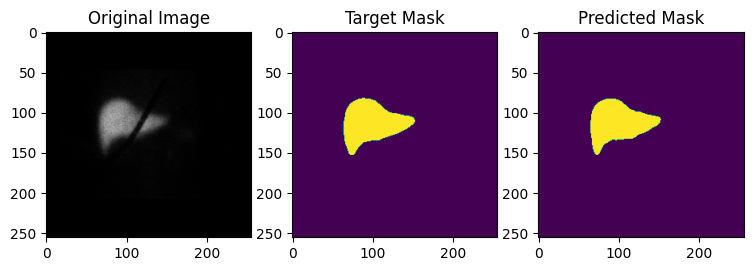

In [12]:
sample_idx = 15
image, target = test_dataset[sample_idx]
thresold = 0.8
preds = F.sigmoid(model(image.unsqueeze(0).to(DEVICE))).squeeze(0)
binary_preds = (preds > thresold)
fig, ax = plt.subplots(1, 3, figsize=(9, 18))
ax[0].imshow(image.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[0].set_title("Original Image") 
ax[1].imshow(target.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[1].set_title("Target Mask")
ax[2].imshow(binary_preds.cpu().numpy()[0])
ax[2].set_title("Predicted Mask") 